In [ ]:
import pandas as pd
# Make HTTP requests
import requests
# Scrape data from an HTML document
from bs4 import BeautifulSoup
# Search and manipulate strings
import re
import os
import string
from concurrent.futures import ThreadPoolExecutor

In [ ]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~—'

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
token = 'GvXtrR6HESUC2WzPBO3xEwwQ5Yym77WaTD7qmMq0iX_seYxWIOnBCZ07lVzJdqo0'

In [ ]:
from google.colab import data_table
data_table.disable_dataframe_formatter()

In [ ]:
with open('artists.txt', 'r') as f:
  artists = f.read()
  artists = artists.split('\n')

with open('./englishST.txt', "r") as f:
  sw = [word.strip('\n') for word in f]
  sw = [word.translate(str.maketrans('', '', string.punctuation)) for word in sw]

In [ ]:
# Get artist object from Genius API
def request_artist_info(artist_name, page):
  base_url = 'https://api.genius.com'
  headers = {'Authorization': 'Bearer ' + token}
  search_url = base_url + '/search?per_page=10&page=' + str(page)
  data = {'q': artist_name}
  response = requests.get(search_url, data=data, headers=headers)
  return response


# Get Genius.com song url's from artist object
def request_song_url(artist_name, song_cap):
  page = 1
  songs = []
  
  while True:
    response = request_artist_info(artist_name, page)
    json = response.json()
    # Collect up to song_cap song objects from artist
    song_info = []
    nw_terms = ['(Remix)', '(Clean)', '(Extended Mix)', '(remix)', '(Extended Version)', '(Insert)', '(REMIX)']
    for hit in json['response']['hits']:
      if artist_name.lower() == hit['result']['primary_artist']['name'].lower():
        if not any(term in hit['result']['full_title'] for term in nw_terms):
          song_info.append(hit)
  
    # Collect song URL's from song objects
    for song in song_info:
      if (len(songs) < song_cap):
        url = song['result']['url']
        songs.append(url)
          
    if (len(songs) == song_cap):
      break
    else:
      page += 1
      
  print('Found {} songs by {}'.format(len(songs), artist_name))
  return songs

In [ ]:
# Scrape lyrics from a Genius.com song URL
def scrape_song_lyrics(url):
    
    page = requests.get(url)
    html = BeautifulSoup(page.text.replace('<br/>', '\n'), 'html.parser')
    name = html.findAll('h1')[0].text
    index = 'Not Found'
    try:
      date = html.findAll("div", class_=re.compile("HeaderMetadata__Section"))
      for i in range(len(date)):
        if 'Release Date' in str(date[i]):
          index = i
          break
      date = date[index].text
      date = re.sub(r'Release Date', '', date)
    except:
      date = index

    try:
      div = html.find("div", class_=re.compile("^lyrics$|Lyrics__Root|Lyrics__Container"))
      lyrics = div.get_text()
    except:
      lyrics = ''
      return name, date, lyrics

    return name, date, lyrics
# DEMO
# scrape_song_lyrics(songs[9])

In [ ]:
def clean_lyrics(lyrics, sw=sw):
  #remove identifiers like chorus, verse, etc
  lyrics = re.sub(r'[\(\[].*?[\)\]]', '', lyrics)

  # Gaps between verses
  lyrics = re.sub('\n{2}', ' ', lyrics)

  # Remove the embed tag
  lyrics = re.sub(r"((\d*)(.*)(\d+)(\S*))*(e|E)mbed", '', lyrics)
  
  # Remove the \u200b tag
  lyrics = re.sub(r"\u200b", "", lyrics)

  # Spliting the lyrics by break lines
  lyrics = lyrics.split("\n")

  # Removing the first line (name of the song)
  lyrics = lyrics[1:]
  lyrics = ' '.join(lyrics)

  # Removing extra spaces
  lyrics = [word.strip().lower() for word in lyrics.split(" ") if word != '']

  # Removing punctuation
  lyrics = [word.translate(str.maketrans('', '', string.punctuation)) for word in lyrics]

  lyrics = ' '.join(lyrics)

  return lyrics

In [ ]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~—'

### Exemplo de execução + resultado

In [ ]:
name, date, lyrics = scrape_song_lyrics('https://genius.com/Public-enemy-fight-the-power-lyrics')

In [ ]:
song = {"Artist": ["Public Enemy"], "Song": [name], "Date": [date], "Lyrics": [clean_lyrics(lyrics)]}

In [ ]:
df = pd.DataFrame()
song = pd.DataFrame(song)
df = pd.concat([df, song], ignore_index=False)

In [ ]:
df

,Artist,Song,Date,Lyrics
0,Public Enemy,Fight the Power,"June 1, 1989",yet our best trained best educated best equipp...


### Criando DF's para todos os artistas

In [ ]:
def create_lyrics_df(artists_names, page):
  df = pd.DataFrame()
  for artist in artists_names:
    songs = request_song_url(artist, page)
    with ThreadPoolExecutor() as pool:
      response_list = list(pool.map(scrape_song_lyrics, songs))
    for song in response_list:
      name, date, lyrics = song
      lyrics = clean_lyrics(lyrics)
      song = {"Artist": [artist], "Song": [name], "Date": [date], "Lyrics": [lyrics]}
      song = pd.DataFrame(song)
      df = pd.concat([df, song], ignore_index=True)
  return df

In [ ]:
df = create_lyrics_df(artists, 50)

In [ ]:
df.to_csv('data.csv', index=False)

In [ ]:
df = pd.read_csv('data.csv')
#df = pd.read_csv('data_clean.csv')

In [ ]:
df.head()

,Artist,Song,Date,Lyrics
0,Public Enemy,Fight the Power,"June 1, 1989",yet our best trained best educated best equipp...
1,Public Enemy,Bring the Noise,"November 1, 1987",too black too strong yo chuck these honey drip...
2,Public Enemy,Don’t Believe the Hype,"June 1, 1988",dont— dont— dont— dont— dont— dont— dont— back...
3,Public Enemy,Harder Than You Think,"August 13, 2007",yo chuck bust a move man i was on my way up he...
4,Public Enemy,Welcome to the Terrordome,"January 1, 1990",hey this— this is a journey— —jour— —journey t...


In [ ]:
string.punctuation += '—'

In [ ]:
def remove_noise(lyrics):  
  lyrics = lyrics.split(" ")

  # Removing punctuation
  lyrics = [word.translate(str.maketrans('', '', string.punctuation)) for word in lyrics]
  
  # Removing stopwords
  lyrics = [word for word in lyrics if word not in sw and len(word) > 2]

  # Joining/Lowercasing the words
  lyrics = ' '.join(lyrics)

  return lyrics

In [ ]:
df = df.fillna("instrumental")
df['CleanLyrics'] = df['Lyrics'].apply(remove_noise)

In [ ]:
df

,Artist,Song,Date,Lyrics,CleanLyrics
0,Public Enemy,Fight the Power,"June 1, 1989",yet our best trained best educated best equipp...,trained educated equipped prepared troops refu...
1,Public Enemy,Bring the Noise,"November 1, 1987",too black too strong yo chuck these honey drip...,black strong chuck honey drippers fronting sho...
2,Public Enemy,Don’t Believe the Hype,"June 1, 1988",dont— dont— dont— dont— dont— dont— dont— back...,back caught lookin thing thing check bring rol...
3,Public Enemy,Harder Than You Think,"August 13, 2007",yo chuck bust a move man i was on my way up he...,chuck bust move man studio sayin brother stopp...
4,Public Enemy,Welcome to the Terrordome,"January 1, 1990",hey this— this is a journey— —jour— —journey t...,hey journey jour journey sound join welcomeini...
...,...,...,...,...,...
5895,Wale,Legendary,"November 1, 2011",top of the dome wit it or wroten lyrics they a...,top dome wit wroten lyrics grossing million li...
5896,Wale,Bait,"August 17, 2011",work work work work yeah you know i got that w...,work work work work yeah work baby mamas leave...
5897,Wale,The War,"August 3, 2010",look i just want to make you better i think i ...,make save bipolar love hate grew disdain hate ...
5898,Wale,Back 2 Ballin,Not Found,you niggas serving up a bad batch too much bak...,niggas serving bad batch bakin bakin bakin bak...


## Palavras mais frequentes ao longo do tempo

In [ ]:
from tqdm.notebook import tqdm
tqdm.pandas()

In [ ]:
import nltk

tokenizer = nltk.tokenize.RegexpTokenizer('\w+')

In [ ]:
tokens = []
for lyric in df['CleanLyrics'].tolist():
  for word in tokenizer.tokenize(str(lyric)):
    tokens.append(word)

In [ ]:
len(tokens)

1441062

In [ ]:
def clean_noise(tokens):
  commom_terms = ['nigga', 'niggas', 'shit', 'yeah', 'fuck', 'back', 'bitch',
                  'make', 'put', 'gon', 'hit', 'ima', 'wanna', 'gonna', 'bitches',
                  'suck', 'pussy', 'dick', 'ass', 'motherfucker', 'motherfuckers',
                  'motherfuckin', 'motherfucking', 'fuckin', 'hey', 'yea', 'im', 'yall'] 

  tokens = [word for word in tokens if word not in commom_terms]
  return tokens

In [ ]:
tokens_filtered = clean_noise(tokens)

In [ ]:
len(tokens_filtered)

1289080

In [ ]:
fd = nltk.FreqDist(tokens_filtered)

In [ ]:
t = []
c = []
for token, count in fd.most_common(20):
  t.append(token)
  c.append(count)

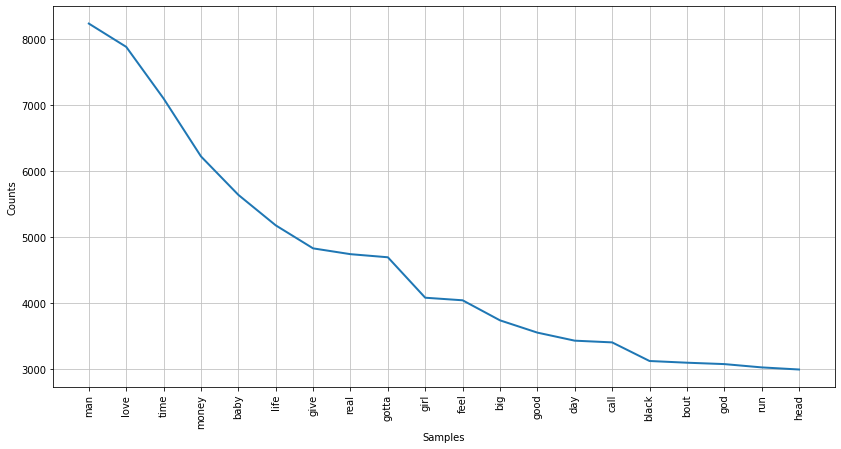

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(14,7))
fd.plot(20)

## Tamanho das letras das músicas por década

In [ ]:
# Desconsiderando as músicas sem data de lançamento identificada
temp = df[df.Date != "Not Found"]

### Separando as letras por décadas

*   1980
*   1990
*   2000
*   2010





In [ ]:
docs_80s = temp[temp.Date.str.slice(-4) < '1990'].reset_index(drop=True)
docs_90s = temp[(temp.Date.str.slice(-4) >= '1990') & (temp.Date.str.slice(-4) < '2000')].reset_index(drop=True)
docs_00s = temp[(temp.Date.str.slice(-4) >= '2000') & (temp.Date.str.slice(-4) < '2010')].reset_index(drop=True)
docs_10s = temp[(temp.Date.str.slice(-4) >= '2010')].reset_index(drop=True)

In [ ]:
# Removendo outliers que atrapalham a visualização dos dados
y1 = [len(lyric) for lyric in docs_80s['Lyrics'] if len(lyric) <= 10000]
y2 = [len(lyric) for lyric in docs_90s['Lyrics'] if len(lyric) <= 10000]
y3 = [len(lyric) for lyric in docs_00s['Lyrics'] if len(lyric) <= 10000]
y4 = [len(lyric) for lyric in docs_10s['Lyrics'] if len(lyric) <= 10000]

In [ ]:
len(y1), len(y2), len(y3), len(y4)

(234, 1360, 1087, 3046)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
data = {"1980": y1, "1990": y2, "2000": y3, "2010": y4}

In [ ]:
test_data = pd.DataFrame([data], index=[0])

In [ ]:
test_data = test_data.T
test_data.columns = ['arrays']

In [ ]:
test_data

,arrays
1980,"[2543, 3187, 4331, 3400, 3981, 3941, 2367, 330..."
1990,"[3933, 2195, 3694, 2574, 3991, 2510, 3397, 244..."
2000,"[3885, 2163, 1146, 1266, 1132, 2209, 3311, 200..."
2010,"[4443, 2268, 315, 1442, 2819, 1993, 1875, 3371..."


In [ ]:
# Salvando dados para usar na criação dos gráficos do site
test_data.to_csv('lyrics_length.csv', index=False)

## Análise de tópicos

In [ ]:
!pip install bertopic

In [ ]:
def removing_domain_stopwords(lyrics):
  commom_terms = ['nigga', 'niggas', 'shit', 'yeah', 'fuck', 'back', 'bitch',
                  'make', 'man', 'boy', 'ima', 'wanna', 'gonna', 'bitches',
                  'suck', 'pussy', 'dick', 'ass', 'motherfucker', 'motherfuckers',
                  'motherfuckin', 'motherfucking', 'fuckin', 'hey', 'yea', 'im', 'yall'] 

  lyrics = [word for word in lyrics.split(' ') if word not in commom_terms]

  return ' '.join(lyrics)

In [ ]:
# Usando a coluna com os dados limpos e aplicando remoção de 
# alguns termos considerados stopwords do domínio em questão

docs_80s = docs_80s['CleanLyrics'].apply(removing_domain_stopwords)
docs_90s = docs_90s['CleanLyrics'].apply(removing_domain_stopwords)
docs_00s = docs_00s['CleanLyrics'].apply(removing_domain_stopwords)
docs_10s = docs_10s['CleanLyrics'].apply(removing_domain_stopwords)

In [ ]:
len(docs_80s), len(docs_90s), len(docs_00s), len(docs_10s)

(234, 1360, 1092, 3056)

In [ ]:
from bertopic import BERTopic

In [ ]:
topic_model_80s = BERTopic()
topic_model_90s = BERTopic()
topic_model_00s = BERTopic()
topic_model_10s = BERTopic()

topics_80s, probs_80s = topic_model_80s.fit_transform(docs_80s)
topics_90s, probs_90s = topic_model_90s.fit_transform(docs_90s)
topics_00s, probs_00s = topic_model_00s.fit_transform(docs_00s)
topics_10s, probs_10s = topic_model_10s.fit_transform(docs_10s)

### Análise dos tópicos com remoção de SW e termos obscenos

In [ ]:
topic_model_80s.get_topics()

{-1: [('time', 0.028700302624819995),
  ('love', 0.027643272354388123),
  ('rock', 0.02493308441036046),
  ('baby', 0.02324085998674299),
  ('wild', 0.022445530068943596),
  ('put', 0.019225156588465783),
  ('cut', 0.01913094868486988),
  ('girl', 0.017987386376664236),
  ('people', 0.017904422376182953),
  ('beat', 0.01718839133591549)],
 0: [('money', 0.03113538862510041),
  ('shes', 0.03052873149417244),
  ('girl', 0.028935566980791205),
  ('geto', 0.024727673804415158),
  ('girls', 0.022524794704567468),
  ('type', 0.021974823191290585),
  ('guy', 0.021460984696151108),
  ('time', 0.021144230296267795),
  ('give', 0.020912861567601172),
  ('ghetto', 0.017772618004256675)],
 1: [('mic', 0.03989111135543636),
  ('rhyme', 0.03963662458714861),
  ('rhymes', 0.03723635645170683),
  ('time', 0.029633078512947116),
  ('rappers', 0.024068473168241514),
  ('rap', 0.023808103651341075),
  ('rock', 0.023741442501953206),
  ('microphone', 0.02282072883375453),
  ('power', 0.021455092156165003)

In [ ]:
topic_model_90s.get_topics()

{-1: [('time', 0.01372684856695634),
  ('baby', 0.013255849734701274),
  ('love', 0.012961815622888496),
  ('give', 0.012760510360332928),
  ('life', 0.01185271648226589),
  ('real', 0.011629401990221664),
  ('gotta', 0.010501462495129498),
  ('good', 0.010078099592225699),
  ('put', 0.010006781622399218),
  ('hit', 0.009963958239589864)],
 0: [('mic', 0.01545959576111874),
  ('rock', 0.015453866500939658),
  ('rap', 0.015035190191224445),
  ('time', 0.014998602924240231),
  ('mcs', 0.014390715464353313),
  ('rhymes', 0.013342802893669674),
  ('funk', 0.012775308500569502),
  ('rhyme', 0.012343801077519489),
  ('stop', 0.011856997680046772),
  ('check', 0.01137928789173178)],
 1: [('girl', 0.03069328346977934),
  ('love', 0.026338849357758796),
  ('hoes', 0.020444067262177467),
  ('baby', 0.019408511304408477),
  ('sex', 0.017484494246084926),
  ('talk', 0.0161760551586937),
  ('big', 0.015909334545575256),
  ('nasty', 0.014941051599964861),
  ('wit', 0.01418140032152468),
  ('give', 0

In [ ]:
topic_model_00s.get_topics()

{-1: [('love', 0.017300742784811158),
  ('girl', 0.014234640584141596),
  ('time', 0.012242727408329457),
  ('baby', 0.011884155456625852),
  ('give', 0.011290094052843702),
  ('money', 0.010985801287870299),
  ('put', 0.010823661098726735),
  ('stop', 0.00998569694274539),
  ('life', 0.009826918029071863),
  ('big', 0.00964598898704482)],
 0: [('gangsta', 0.028463241416239172),
  ('rap', 0.02511100909679553),
  ('hiphop', 0.01822844435970886),
  ('life', 0.018186743080789432),
  ('live', 0.016144056696835656),
  ('game', 0.016112850391497405),
  ('paper', 0.01473569820181177),
  ('real', 0.01425506309737504),
  ('gun', 0.013042333046291606),
  ('hip', 0.012489603093529663)],
 1: [('cry', 0.04148517837647694),
  ('life', 0.04110160088038328),
  ('pain', 0.03576482522561721),
  ('someday', 0.029993589643739615),
  ('ohhhh', 0.028114550667212752),
  ('hell', 0.025701828101034944),
  ('love', 0.023634518707185078),
  ('lord', 0.02354628668965215),
  ('god', 0.023310191420344153),
  ('feel

In [ ]:
topic_model_10s.get_topics()

{-1: [('love', 0.038996155855525114),
  ('time', 0.03287927132581875),
  ('work', 0.026977517189616426),
  ('money', 0.02553832012470873),
  ('gotta', 0.024736501852285302),
  ('good', 0.02321361372975998),
  ('gon', 0.022708070687659336),
  ('night', 0.022463441269167043),
  ('baby', 0.02131807492811026),
  ('girl', 0.0196373109278561)],
 0: [('love', 0.025184168823060453),
  ('money', 0.024717706517413795),
  ('time', 0.022705244638660686),
  ('gon', 0.02052355469550781),
  ('put', 0.02021959633083631),
  ('baby', 0.01972014709833895),
  ('life', 0.018181335663944625),
  ('real', 0.017076742088427136),
  ('gotta', 0.017061846993496062),
  ('feel', 0.01651905212337298)],
 1: [('morning', 0.08788096349916225),
  ('find', 0.08359543583976971),
  ('late', 0.08325972735087173),
  ('balm', 0.08298387174018099),
  ('time', 0.0821388449446491),
  ('bollective', 0.08037251479862667),
  ('bool', 0.07797644238035313),
  ('night', 0.0694432513171886),
  ('meh', 0.0679613730678262),
  ('bed', 0.0

In [ ]:
topic_model_80s.visualize_barchart()

In [ ]:
fig = topic_model_90s.visualize_barchart(n_words=8, top_n_topics=16, width=220, height=220)
fig.write_html('topics_90s.html')

In [ ]:
fig = topic_model_00s.visualize_barchart(n_words=8, top_n_topics=10, width=220, height=220)
fig.write_html('topics_00s.html')

In [ ]:
topic_model_10s.visualize_barchart()

### Análise dos tópicos feita tirando SW

In [ ]:
topic_model_80s.get_topics()

{-1: [('man', 0.029263831056780095),
  ('time', 0.029240303085069082),
  ('love', 0.027420081370548532),
  ('wild', 0.024027794912371992),
  ('show', 0.020144595883358592),
  ('make', 0.019254008060852243),
  ('back', 0.01898132399292532),
  ('cut', 0.018884498567152064),
  ('baby', 0.01829672626362026),
  ('watch', 0.01756181167109566)],
 0: [('rhyme', 0.03727267270594875),
  ('rock', 0.03628268091084733),
  ('make', 0.034340671423530957),
  ('rhymes', 0.033718224527641005),
  ('mic', 0.0328092540758476),
  ('time', 0.026934708441735938),
  ('rap', 0.021674532466919236),
  ('rappers', 0.020893177347485345),
  ('microphone', 0.020480841044960296),
  ('power', 0.020326991694892965)],
 1: [('man', 0.04230864511704568),
  ('boy', 0.031452895019063655),
  ('girl', 0.029887119413671417),
  ('back', 0.027024568426220894),
  ('geto', 0.027012884360689736),
  ('shes', 0.02561322271200209),
  ('girls', 0.024499266488219307),
  ('money', 0.023310036338052377),
  ('guy', 0.02287647954333033),
  (

In [ ]:
topic_model_90s.get_topics()

{-1: [('niggas', 0.01817066198001391),
  ('shit', 0.01805317849150498),
  ('nigga', 0.01624430276655864),
  ('back', 0.015078036104715786),
  ('fuck', 0.014540702227090014),
  ('man', 0.013740912861889757),
  ('make', 0.012795754686181809),
  ('time', 0.012383368475513572),
  ('yeah', 0.012359200813178997),
  ('wanna', 0.011694520424793534)],
 0: [('love', 0.027590525752466823),
  ('girl', 0.02560938370362197),
  ('baby', 0.019154008525934428),
  ('back', 0.018366388270941947),
  ('make', 0.017727435792552915),
  ('man', 0.015410399689240375),
  ('sex', 0.014691006351230367),
  ('hey', 0.013524285031957546),
  ('rap', 0.01339003707090211),
  ('big', 0.013020007595127787)],
 1: [('nigga', 0.07021214205639176),
  ('niggas', 0.06392403953820573),
  ('fuck', 0.03376399096708037),
  ('shit', 0.03070956816055595),
  ('wet', 0.02189358350065286),
  ('real', 0.019326354872205836),
  ('die', 0.01898897415803844),
  ('man', 0.018281406647823698),
  ('bitch', 0.017358610945404116),
  ('fuckin', 0

In [ ]:
topic_model_00s.get_topics()

{-1: [('shit', 0.019137958237913668),
  ('nigga', 0.01848680348464127),
  ('niggas', 0.01733322230395146),
  ('back', 0.017198835943671522),
  ('yeah', 0.016664964335131933),
  ('make', 0.015381822511825773),
  ('love', 0.01533085414831567),
  ('fuck', 0.01522417972143938),
  ('man', 0.014752151839790652),
  ('wanna', 0.014231279438282052)],
 0: [('niggas', 0.06555752441831746),
  ('nigga', 0.061886920512823206),
  ('fuck', 0.039187207416401935),
  ('shit', 0.031503671983262704),
  ('yall', 0.0314414835375845),
  ('gon', 0.029775582597273833),
  ('bitch', 0.01993524006248598),
  ('blood', 0.019342472195887143),
  ('back', 0.0188305066372479),
  ('give', 0.018189464394235612)],
 1: [('cry', 0.041693853805862297),
  ('life', 0.03558910431177677),
  ('someday', 0.03189124056193735),
  ('hell', 0.030276520946645367),
  ('love', 0.025751864170775574),
  ('lord', 0.024700368849556245),
  ('pain', 0.023328964312760075),
  ('god', 0.02294674202959328),
  ('found', 0.021797090245844527),
  ('he

In [ ]:
topic_model_10s.get_topics()

{-1: [('yeah', 0.039489747681227094),
  ('shit', 0.037548192490234146),
  ('nigga', 0.033715221731471415),
  ('fuck', 0.03267795688044844),
  ('work', 0.028923138710833254),
  ('make', 0.02690006799060052),
  ('im', 0.026769500404655467),
  ('back', 0.026741061877104334),
  ('niggas', 0.026491328468335656),
  ('bitch', 0.02404752776256767)],
 0: [('nigga', 0.04731636371624209),
  ('niggas', 0.03915113500051258),
  ('yeah', 0.038832928809115985),
  ('shit', 0.0365866527060166),
  ('fuck', 0.03511188712019201),
  ('bitch', 0.03365315613837825),
  ('back', 0.027873095844642266),
  ('make', 0.024702361557163714),
  ('love', 0.024272302952159094),
  ('money', 0.022925026359756445)],
 1: [('weed', 0.1238929025567668),
  ('smoke', 0.12307057723796644),
  ('blowing', 0.10936901820918635),
  ('juicy', 0.10428670713282168),
  ('wax', 0.09205156827491559),
  ('high', 0.08034222480340585),
  ('higher', 0.0698817804229512),
  ('kush', 0.0639951395685724),
  ('smoking', 0.05061098559457366),
  ('rol

In [ ]:
topic_model_00s.visualize_hierarchy()

# Análise de Sentimento

In [ ]:
import transformers

In [ ]:
from transformers import pipeline, AutoTokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('j-hartmann/emotion-english-distilroberta-base')

Downloading:   0%|          | 0.00/294 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.98k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [ ]:
classifier = pipeline("text-classification", model='j-hartmann/emotion-english-distilroberta-base', tokenizer=tokenizer, truncation=True, max_length=512, device=0)

Downloading:   0%|          | 0.00/313M [00:00<?, ?B/s]

## Analise usando dados sem limpeza de SW

In [ ]:
temp2 = df_temp[df_temp.Date != "Not Found"]
temp2 = df_temp.fillna('instrumental')

In [ ]:
docs_80s_temp = temp2[temp2.Date.str.slice(-4) < '1990'].reset_index(drop=True)
docs_90s_temp = temp2[(temp2.Date.str.slice(-4) >= '1990') & (temp2.Date.str.slice(-4) < '2000')].reset_index(drop=True)
docs_00s_temp = temp2[(temp2.Date.str.slice(-4) >= '2000') & (temp2.Date.str.slice(-4) < '2010')].reset_index(drop=True)
docs_10s_temp = temp2[(temp2.Date.str.slice(-4) >= '2010')].reset_index(drop=True)

### Emoções das músicas década de 1980

In [ ]:
emt_80s = classifier(docs_80s['Lyrics'].tolist())
emt_80s = [song['label'] for song in emt_80s]

In [ ]:
docs_80s['Emotion'] = emt_80s

In [ ]:
docs_80s['Emotion'].value_counts()

anger       93
joy         35
fear        34
sadness     30
surprise    23
neutral     19
Name: Emotion, dtype: int64

In [ ]:
docs_80s[docs_80s['Emotion'] == 'anger']['Artist'].value_counts()

N.W.A              12
Kool Moe Dee       12
Public Enemy       11
Beastie Boys        9
Eazy-E              8
Geto Boys           8
Queen Latifah       7
Salt-n-Pepa         6
Big Daddy Kane      6
LL Cool J           4
De La Soul          4
Eric B. & Rakim     3
Slick Rick          2
UGK                 1
Name: Artist, dtype: int64

In [ ]:
docs_80s[docs_80s['Emotion'] == 'joy']['Artist'].value_counts()

Big Daddy Kane     9
Beastie Boys       6
Kool Moe Dee       5
Public Enemy       3
Slick Rick         3
LL Cool J          3
De La Soul         2
Queen Latifah      1
Eric B. & Rakim    1
Salt-n-Pepa        1
Eazy-E             1
Name: Artist, dtype: int64

In [ ]:
docs_80s[docs_80s['Emotion'] == 'fear']['Artist'].value_counts()

Eric B. & Rakim    6
LL Cool J          5
N.W.A              3
Beastie Boys       3
De La Soul         3
Public Enemy       2
Salt-n-Pepa        2
Eazy-E             2
Big Daddy Kane     2
Kool Moe Dee       2
Queen Latifah      1
Slick Rick         1
Kool G Rap         1
Geto Boys          1
Name: Artist, dtype: int64

In [ ]:
docs_80s[docs_80s['Emotion'] == 'sadness']['Artist'].value_counts()

Eric B. & Rakim    7
Beastie Boys       4
Kool Moe Dee       4
Public Enemy       3
De La Soul         3
Slick Rick         2
LL Cool J          2
Queen Latifah      1
Salt-n-Pepa        1
Big Daddy Kane     1
N.W.A              1
Geto Boys          1
Name: Artist, dtype: int64

In [ ]:
docs_80s[docs_80s['Emotion'] == 'surprise']['Artist'].value_counts()

Beastie Boys       7
Eric B. & Rakim    3
Slick Rick         3
Salt-n-Pepa        2
LL Cool J          2
Kool Moe Dee       2
Public Enemy       1
Eazy-E             1
Big Daddy Kane     1
De La Soul         1
Name: Artist, dtype: int64

### Emoções das músicas da década de 1990

In [ ]:
emt_90s = classifier(docs_90s['Lyrics'].tolist())
emt_90s = [song['label'] for song in emt_90s]

In [ ]:
docs_90s['Emotion'] = emt_90s

In [ ]:
docs_90s['Emotion'].value_counts()

anger       605
fear        191
sadness     190
surprise    155
joy         129
neutral      89
disgust       1
Name: Emotion, dtype: int64

In [ ]:
docs_90s[docs_90s['Emotion'] == 'anger']['Artist'].value_counts()[:10]

The Notorious B.I.G.    28
Bone Thugs-N-Harmony    27
Geto Boys               22
Mobb Deep               21
Ol’ Dirty Bastard       20
DMX                     20
Ice Cube                20
Eazy-E                  19
Wu-Tang Clan            19
N.W.A                   18
Name: Artist, dtype: int64

In [ ]:
docs_90s[docs_90s['Emotion'] == 'fear']['Artist'].value_counts()[:10]

2Pac            10
Mobb Deep        8
Gang Starr       8
Fat Joe          8
Redman           8
OutKast          7
Das EFX          7
Wu-Tang Clan     6
Salt-n-Pepa      6
KRS-One          6
Name: Artist, dtype: int64

In [ ]:
docs_90s[docs_90s['Emotion'] == 'sadness']['Artist'].value_counts()[:10]

2Pac                    11
OutKast                  8
Cypress Hill             7
Salt-n-Pepa              7
Scarface                 7
Gang Starr               6
DMX                      6
Diddy                    6
The Notorious B.I.G.     6
Redman                   5
Name: Artist, dtype: int64

In [ ]:
docs_90s[docs_90s['Emotion'] == 'joy']['Artist'].value_counts()[:10]

Queen Latifah      9
Das EFX            7
Slick Rick         7
Big Daddy Kane     7
LL Cool J          6
Eric B. & Rakim    5
Salt-n-Pepa        5
Foxy Brown         5
Lauryn Hill        4
Method Man         4
Name: Artist, dtype: int64

In [ ]:
docs_90s[docs_90s['Emotion'] == 'surprise']['Artist'].value_counts()[:10]

KRS-One                 9
Das EFX                 9
The Notorious B.I.G.    6
Mobb Deep               6
Slick Rick              6
Public Enemy            5
Beastie Boys            5
UGK                     5
A Tribe Called Quest    5
Gang Starr              4
Name: Artist, dtype: int64

### Emoções das musicas da década de 2000

In [ ]:
emt_00s = classifier(docs_00s['Lyrics'].tolist())
emt_00s = [song['label'] for song in emt_00s]

In [ ]:
docs_00s['Emotion'] = emt_00s

In [ ]:
docs_00s['Emotion'].value_counts()

anger       419
sadness     221
fear        138
surprise    134
joy         105
neutral      70
disgust       5
Name: Emotion, dtype: int64

In [ ]:
docs_00s[docs_00s['Emotion'] == 'anger']['Artist'].value_counts()[:10]

Immortal Technique    24
Xzibit                21
50 Cent               21
Big Pun               16
Ludacris              15
Cam’ron               14
Canibus               13
RZA                   13
Ghostface Killah      13
Lil’ Kim              12
Name: Artist, dtype: int64

In [ ]:
docs_00s[docs_00s['Emotion'] == 'sadness']['Artist'].value_counts()[:10]

Ja Rule        10
Lauryn Hill    10
DMX             9
Styles P        8
Talib Kweli     8
Jadakiss        8
Beyoncé         7
Cam’ron         7
Eminem          7
MF DOOM         6
Name: Artist, dtype: int64

In [ ]:
docs_00s[docs_00s['Emotion'] == 'fear']['Artist'].value_counts()[:10]

Missy Elliott    9
Canibus          6
50 Cent          6
Ja Rule          6
Fat Joe          5
Lupe Fiasco      4
Styles P         4
Xzibit           4
Talib Kweli      4
Q-Tip            4
Name: Artist, dtype: int64

In [ ]:
docs_00s[docs_00s['Emotion'] == 'surprise']['Artist'].value_counts()[:10]

Nelly               8
MF DOOM             6
Ludacris            6
Cam’ron             5
OutKast             5
Ghostface Killah    4
Xzibit              4
Ja Rule             4
Twista              4
Kool Keith          4
Name: Artist, dtype: int64

In [ ]:
docs_00s[docs_00s['Emotion'] == 'joy']['Artist'].value_counts()[:10]

Q-Tip            8
Cam’ron          8
JAY-Z            7
Nelly            6
Missy Elliott    5
MF DOOM          4
Twista           4
Busta Rhymes     4
Jadakiss         4
UGK              4
Name: Artist, dtype: int64

### Emoções das músicas da década de 2010

In [ ]:
emt_10s = classifier(docs_10s['Lyrics'].tolist())
emt_10s = [song['label'] for song in emt_10s]

In [ ]:
docs_10s['Emotion'] = emt_10s

In [ ]:
docs_10s['Emotion'].value_counts()

anger       1194
sadness      737
fear         454
surprise     330
joy          270
neutral      226
disgust        3
Name: Emotion, dtype: int64

In [ ]:
docs_10s[docs_10s['Emotion'] == 'anger']['Artist'].value_counts()[:10]

A$AP Ferg          30
Freddie Gibbs      30
Run The Jewels     30
YG                 29
Cardi B            28
21 Savage          27
Young Thug         26
Earl Sweatshirt    25
Juicy J            25
Kendrick Lamar     24
Name: Artist, dtype: int64

In [ ]:
docs_10s[docs_10s['Emotion'] == 'sadness']['Artist'].value_counts()[:10]

Post Malone         22
Kevin Gates         20
Mac Miller          20
Childish Gambino    19
BROCKHAMPTON        19
Vince Staples       18
J. Cole             18
Bryson Tiller       16
Wale                16
Lil Baby            16
Name: Artist, dtype: int64

In [ ]:
docs_10s[docs_10s['Emotion'] == 'fear']['Artist'].value_counts()[:10]

Pop Smoke           14
Denzel Curry        13
Big K.R.I.T.        11
J. Cole             11
Childish Gambino    11
Tech N9ne           10
Flatbush Zombies    10
Run The Jewels      10
Joey Bada$$         10
BROCKHAMPTON        10
Name: Artist, dtype: int64

In [ ]:
docs_10s[docs_10s['Emotion'] == 'surprise']['Artist'].value_counts()[:10]

Big Sean              15
Post Malone           13
2 Chainz              11
Childish Gambino      11
Tyler, The Creator    11
Mac Miller             9
Logic                  9
Doja Cat               8
21 Savage              8
Nicki Minaj            7
Name: Artist, dtype: int64

In [ ]:
docs_10s[docs_10s['Emotion'] == 'joy']['Artist'].value_counts()[:10]

Drake             9
Pop Smoke         8
Kendrick Lamar    8
Future            8
Wale              7
Fat Joe           7
Beyoncé           7
JID               7
Nipsey Hussle     7
Mac Miller        7
Name: Artist, dtype: int64